<a href="https://colab.research.google.com/github/YaleGu/DSSS_final/blob/main/DSSS_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis of London crime data -- similarity between boroughs and prediction
      
### Student Number:20041295

#### **Statement:** 
#### Forecasting models for time series based on ANN and LSTM require **keras**. **TensorFlow** needs to be installed before **keras**.

#### In addition, this work is completed on Colab. Some packages require **!pip install** on Colab but do not need it on Jupyter Notebook (e.g. geopandas). This causes some differences in the code used to load packages.

#### **Code at** [GitHub](https://github.com/YaleGu/DSSS_final)

## 1. Introduction and Literature review
Traditionally, the law enforcement of police has focused on crime cases and criminals. They intervene or solve crimes that are occurring or have occurred by receiving calls or patrolling. This ex-post tactic makes each case costly in terms of manpower, material and financial resources. If past crime data can be analysed and patterns can be identified, we can build forecast models and help law enforcement officers mitigate crime-related problems and optimise the deployment of limited resources (Marzan et al., 2017) with them. The police can reduce potential crime cases by taking action based on accurate short-term predictions. For example, they could intensify patrols in hotspots in advance, provide early alerts of crime to residents.

In order to have a deeper understanding of crime patterns, many data mining techniques have been used for the study of crime data. For example, clustering can be used to identify suspects who have committed crimes in a similar way, or to distinguish between groups belonging to different gangs(Chen et al., 2004). Zhang et al. (2015) use spatio-temporal clustering to study the aggregation characteristics of different crime types.

Many scholars have studied the time series of crime data from different perspectives with various models to make predictions. The most classic model is ARIMA, which regresses past data points to predict recent points(Chen et al., 2008). It assumes that the time series is generated by a linear process. Therefore the model is hardly a good solution for non-linear problems(Khashei et al., 2009). To improve the accuracy and precision of forecasting, many machine learning and deep learning models as well as algorithms are applied to the study of time series. Chandra et al. (2008) propose a technique based on Dynamic Time Wrapping (DTW) and parametric Minkowski model for detecting similar crime trends in different crime sequences across multiple locations. And it is applied to the prediction of forthcoming crime trends. There are also other models such as support vector machines (SVMs)(Kim, 2003), artificial neural networks (ANN)(Fernandes and Teixeira, 2009).

In this paper, we will first perform K-means clustering after calculating the similarity between the time series of total crime cases in each borough using Dynamic Time Warping (DTW), and then to see if the clustering results are spatially correlated from the map. Next, crime types are used as features for hierarchical clustering. Finally, Artificial Neural Networks (ANN) and Long Short-Term Memory (LSTM) are applied to predict the change in total crime cases in London over time.

Data is obtained from the [London Datastore](https://data.london.gov.uk/dataset/recorded_crime_summary) (Mayor of London). This dataset records the number of crimes of each category monthly in London from 2008-2018 (borough level).





In [ ]:
# Packages for data manipulation and processing
import math
import numpy as np
import pandas as pd
!pip install geopandas
import geopandas as gpd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Packages for clustering
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster import hierarchy

!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

# Packages for deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM


# Packages for visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from google.colab import files

## 2 Research question
With a variety of data mining methods, we will analyse the London crime dataset and attempt to answer the following questions:

1) Which boroughs share similar temporal characteristics of crime cases and are they spatially correlated?

2) Which boroughs have a similar composition of cases of different crime types and are they spatially aggregated?

3) Which has better results, ANN or LSTM for crime case prediction?

## 3 Methodology
### Dynamic Time Warping

Dynamic Time Warping (DTW) is a measure of the similarity between two time series. The basic principle of DTW is to warp the series under the time axis to achieve better alignment before comparing the similarity of two time series.

Sometimes the two time series that need to be compared for similarity may not be of equal length, and in some cases, two time series may simply have displacement on the time axis (the two time series are identical after eliminating the displacement). In these complex scenarios, the distance (or similarity) between time series cannot be effectively estimated with Euclidean distances. We therefore choose DTW to measure the similarity between time series.

### Unsupervised Learning

***K-means clustering***

K-means clustering is one of the most frequently used clustering algorithms. It has the following steps：

(1) Select the number of clusters K to be clustered into, and pick k centroids.

(2) For each sample, find the centroid nearest to it. The points nearest to the same centroid are a class.

(3) After one sample has been assigned, the cluster centroids are recalculated based on the existing samples in the clusters.

(4) Evaluate whether each sample point is in the same cluster after the centroids are recalculated. If so, the algorithm terminates, otherwise it returns to (2).

***Hierarchical clustering***

Hierarchical clustering starts by calculating the distances between samples. The points with the closest distances are merged into the same class each time. Then, the distances between classes are calculated again, and the closest classes are merged into one large class. The merging continues until all samples have been combined into one class.

According to the direction of hierarchical decomposition, hierarchical clustering algorithms can be divided into bottom-up and top-down. Bottom-up is where every sample is a class at the beginning, and then the linkage is used to find similarities to form a cluster. The top-down approach is the opposite, starting with all individuals belonging to a class and then eliminating those not in the same cluster according to the linkage, until every point becomes one class.


### Deep Learning

***Artificial Neural Network***

Artificial Neural Network (ANN) is a mathematical model that applies structures like synaptic connections in the brain for information processing. The network contains many interconnected neurons for the purpose of transferring information and processing data, which is an adaptive computational model. It does not need to consider the distribution characteristics of data and is able to portray the non-linear relationship.

Back propagation is a common algorithm used in conjunction with optimisation methods such as gradient descent to train ANN. If the prediction output exceeds the set prediction error value, it will propagate backwards, continuously adjust the weights and thresholds so that the prediction value of the model keeps approaching the actual values.


***Recurrent Neural Network (RNN) and Long Short-Term Memory (LSTM)***

RNN interconnects neurons between hidden layers so that the input to the hidden layer is not only the output of the current input layer but also the output of the previous hidden layer. In this way, RNN can remember previous information in the network. It has broadly the same structure as an artificial neural network, but differs in the connectivity between the hidden layers, i.e. the weights between the hidden layers are added. If the training set contains T moments of data, RNN will expand into a feedforward neural network with T hidden layers. Theoretically, RNN can handle series data of arbitrary length, but when dealing with infinite series data, the multilayer feedforward neural network is also infinite in layers. Therefore, in practice, it is often assumed that the current state is only related to a finite number of previous states to reduce the complexity. 

Although RNN can effectively handle non-linear time series, there are still two problems: (1) RNN cannot handle time series with long lags due to gradient vanishing and gradient exploding problems; (2) training RNN models requires a predefined target delay, but it is difficult to automatically obtain the optimal value for this parameter in practice. 

This leads to the emergence of the LSTM model. LSTM replaces the RNN cells in the hidden layer with LSTM cells so that they can have long-term memory. The training process of the LSTM model can be roughly divided into four steps: (1) computing the output values of the LSTM cells according to the forward calculation method; (2) calculating the error term of each LSTM cell in the reverse direction, including two back propagation directions by time and network level; (3) according to the corresponding error term, calculating the gradient of each weight; and (4) applying the gradient-based optimization algorithm to update the weights. In addition, the Adaptive Moment Estimation (Adam) is chosen as the optimisation algorithm in our paper. The Adam algorithm is an effective gradient-based stochastic optimisation method that combines the advantages of the AdaGrad and RMSProp algorithms to calculate adaptive learning rates for different parameters and uses less storage space. Compared to other stochastic optimisation methods, the Adam method performs better in practice overall.


## 4 Analysis and Results
### **Data Overview and Preprocessing**
First we import the packages we need for the analysis.

In [ ]:
# import data set

url = 'https://raw.githubusercontent.com/YaleGu/DSSS_final/main/MPS_Borough_Level_Crime_Historic.csv'
df= pd.read_csv(url)
df.head(5)

,Borough,Major Category,Minor Category,200801,200802,200803,200804,200805,200806,200807,200808,200809,200810,200811,200812,200901,200902,200903,200904,200905,200906,200907,200908,200909,200910,200911,200912,201001,201002,201003,201004,201005,201006,201007,201008,201009,201010,201011,201012,201101,...,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
0,Barking and Dagenham,Burglary,Burglary in a Dwelling,82,71,87,74,74,103,113,96,95,107,120,148,180,149,155,112,135,119,149,124,159,180,184,157,169,161,123,118,102,124,137,153,136,116,140,105,165,...,77,105,111,119,103,86,73,47,77,63,55,54,49,60,73,100,118,124,93,101,129,71,95,83,81,122,88,124,143,134,122,75,93,77,94,84,99,94,106,163
1,Barking and Dagenham,Burglary,Burglary in Other Buildings,59,68,56,53,57,39,44,37,52,65,52,67,51,67,64,80,69,51,56,49,58,39,51,55,53,47,49,49,58,59,47,46,51,52,62,49,50,...,50,34,36,32,44,53,32,42,42,47,32,33,45,40,24,19,40,78,67,53,68,57,72,47,42,47,53,49,67,48,61,65,39,52,40,36,50,61,60,50
2,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,79,52,55,73,63,80,73,75,59,68,71,55,70,74,56,61,65,69,62,59,58,44,56,48,50,67,39,63,58,55,67,65,39,59,51,48,59,...,28,28,36,38,36,39,50,36,58,30,48,38,31,29,32,26,28,31,36,31,32,46,48,49,28,35,32,28,34,23,30,29,32,29,21,29,23,35,21,15
3,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,138,118,158,126,96,116,123,103,102,106,111,115,107,173,134,151,97,103,80,72,88,92,66,95,69,114,97,81,114,80,78,80,93,80,56,71,...,68,65,80,105,75,83,73,61,81,73,69,68,61,69,67,59,65,62,61,61,71,59,66,77,72,63,48,57,60,51,53,64,64,67,69,42,38,42,47,33
4,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,20,19,20,23,16,12,17,18,14,14,14,9,22,21,16,24,19,12,9,21,7,15,12,12,12,18,13,17,16,14,27,16,10,12,21,9,14,...,10,9,16,10,13,10,21,13,13,18,15,16,11,12,16,8,10,6,13,9,7,12,6,8,7,12,11,10,10,5,6,9,8,8,7,7,11,5,4,7


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Columns: 135 entries, Borough to 201812
dtypes: int64(132), object(3)
memory usage: 1.1+ MB


We import the data and then provide an overview of it. The London crime data records the number of different types of crime in each borough in monthly intervals. The time frame for the data is from January 2008 to December 2018, for a total of 132 months. That is, each time series has 132 time points. Next we will check if there are any missing values in the dataset and how the data is classified.

In [ ]:
# check missing value

df.isnull().sum(axis=0).sort_values(ascending=False)

201812     0
201111     0
201009     0
201010     0
201011     0
          ..
201509     0
201510     0
201511     0
201512     0
Borough    0
Length: 135, dtype: int64

In [ ]:
df['Borough'].unique()

array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'],
      dtype=object)

In [ ]:
df['Major Category'].unique()

array(['Burglary', 'Criminal Damage', 'Drugs', 'Fraud or Forgery',
       'Other Notifiable Offences', 'Robbery', 'Sexual Offences',
       'Theft and Handling', 'Violence Against the Person'], dtype=object)

In [ ]:
df['Minor Category'].unique()

array(['Burglary in a Dwelling', 'Burglary in Other Buildings',
       'Criminal Damage To Dwelling', 'Criminal Damage To Motor Vehicle',
       'Criminal Damage To Other Building', 'Other Criminal Damage',
       'Drug Trafficking', 'Other Drugs', 'Possession Of Drugs',
       'Counted per Victim', 'Other Fraud & Forgery', 'Going Equipped',
       'Other Notifiable', 'Business Property', 'Personal Property',
       'Other Sexual', 'Rape', 'Handling Stolen Goods',
       'Motor Vehicle Interference & Tampering', 'Other Theft',
       'Other Theft Person', 'Theft From Motor Vehicle',
       'Theft From Shops', 'Theft/Taking Of Motor Vehicle',
       'Theft/Taking of Pedal Cycle', 'Assault with Injury',
       'Common Assault', 'Grievous Bodily Harm', 'Harassment', 'Murder',
       'Offensive Weapon', 'Other violence', 'Wounding/GBH'], dtype=object)

As can be seen above, there are no missing values in the data. The crime data contains cases from the 32 boroughs (without city of London), with crime types divided into 9 major categories and over 30 minor categories. Given the appropriate number of major categories, we will use them as the features in subsequent clustering of crime types.

<Figure size 1080x1080 with 0 Axes>

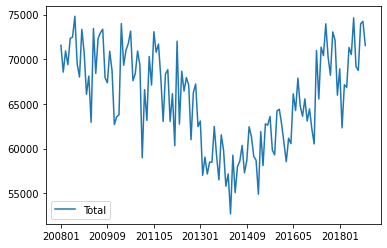

In [ ]:
# total crime cases overview

dfoverview = df.drop(['Borough','Major Category','Minor Category'],axis=1)
dfoverview.loc['Total']= dfoverview.sum(axis=0)
dfoverview = pd.DataFrame(dfoverview.loc['Total'])
plt.figure(figsize=(15,15))
dfoverview.plot()

In [ ]:
# Convert data type of date and set index

dfoverview.insert(loc=0, column='Date', value=dfoverview.index)
dfoverview['DateTime'] = dfoverview['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))

In [ ]:
dfoverview = dfoverview.set_index(['DateTime'], drop=True)

In [ ]:
dfoverview = dfoverview.drop(['Date'],axis=1)

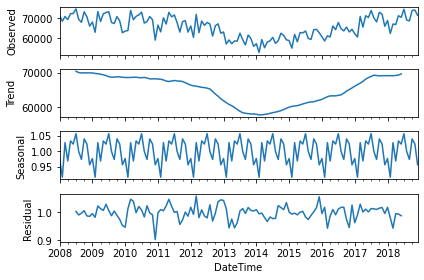

In [ ]:
# decompose time series to for in-depth exploration
decomposition = sm.tsa.seasonal_decompose(dfoverview,model='multiplicative')
fig = decomposition.plot()
fig.show()

The time series of total cases for 32 boroughs illustrates a steady decline in crime cases from 2008-2014. The rate of reduction was slower from 2008 to mid-2012 and began to accelerate from 2012-2014, eventually reaching its lowest value in the study timeframe around 2014. However, from 2014 onwards, crime cases began to rise and did so at a greater rate than the previous decline. In the next section, we delve into the time series of total monthly crime cases for each borough and try to explore the commonalities and differences between them.

### **4.1 Time series clustering**

Given that the data required for the different parts of our analysis later varies, we will transform the data structure again before each technique is used.

In [ ]:
df1 = df.drop(['Major Category','Minor Category'],axis=1)
df1 = df1.groupby('Borough').sum()
df1 = df1.T
df1

Borough,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith and Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington and Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
200801,1686,2206,1396,2280,2190,2731,2730,2889,2332,2697,2502,1975,2432,1158,1555,2315,1997,2349,1838,968,2896,2673,1171,3175,1981,979,3459,1154,2425,2099,2299,5027
200802,1636,1939,1344,2062,2087,2696,2475,2855,2150,2384,2385,1838,2332,1143,1531,2171,2034,2571,1696,949,2914,2586,1215,2709,1870,996,3325,1032,2359,2037,2208,5033
200803,1599,2196,1454,2280,2153,2874,2614,2617,2163,2624,2580,1760,2427,1219,1449,2224,2011,2484,1913,1066,2868,2509,1247,2937,2078,984,3323,1145,2518,2123,2249,5251
200804,1732,2195,1363,2044,2106,2737,2444,2608,2245,2429,2505,1885,2352,1254,1631,1904,1964,2372,1865,951,2828,2484,1233,2704,2128,942,3343,1133,2640,2145,2186,5042
200805,1625,2374,1354,2315,2232,2871,2745,2856,2179,2660,2697,1882,2341,1255,1543,1925,2015,2350,1936,1025,2971,2897,1300,3015,2032,967,3557,1234,2584,2321,2189,5102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201808,1457,2244,1243,2503,1850,2853,2571,2265,2278,2086,2620,1794,2474,1140,1519,2199,1924,2281,2327,1125,2906,2153,1143,2967,1756,1085,3063,999,2890,1964,2040,5452
201809,1456,2261,1261,2545,1937,2883,2507,2412,2279,2231,2676,1929,2497,1233,1517,2233,2015,2362,1781,1024,2781,2127,1101,2932,1901,1011,2959,965,2838,2028,2100,4977
201810,1578,2545,1336,2708,1968,3045,2795,2544,2434,2268,2871,1952,2530,1389,1603,2505,2363,2614,1792,1186,2895,2373,1232,3118,2084,1148,3223,1056,2917,2178,2153,5578
201811,1540,2560,1395,2720,1985,3124,2624,2590,2485,2223,2874,1899,2686,1402,1665,2631,2245,2355,1889,1115,3028,2239,1214,3134,2108,1199,3143,1017,2884,2076,2148,6052


In [ ]:
df1.insert(loc=0, column='Date', value=df1.index)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 200801 to 201812
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date                    132 non-null    object
 1   Barking and Dagenham    132 non-null    int64 
 2   Barnet                  132 non-null    int64 
 3   Bexley                  132 non-null    int64 
 4   Brent                   132 non-null    int64 
 5   Bromley                 132 non-null    int64 
 6   Camden                  132 non-null    int64 
 7   Croydon                 132 non-null    int64 
 8   Ealing                  132 non-null    int64 
 9   Enfield                 132 non-null    int64 
 10  Greenwich               132 non-null    int64 
 11  Hackney                 132 non-null    int64 
 12  Hammersmith and Fulham  132 non-null    int64 
 13  Haringey                132 non-null    int64 
 14  Harrow                  132 non-null    int64 
 15  Hav

In [ ]:
# Convert data type of date and set index

df1['DateTime'] = df1['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))
df1.head(5)

Borough,Date,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith and Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington and Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,DateTime
200801,200801,1686,2206,1396,2280,2190,2731,2730,2889,2332,2697,2502,1975,2432,1158,1555,2315,1997,2349,1838,968,2896,2673,1171,3175,1981,979,3459,1154,2425,2099,2299,5027,2008-01-01
200802,200802,1636,1939,1344,2062,2087,2696,2475,2855,2150,2384,2385,1838,2332,1143,1531,2171,2034,2571,1696,949,2914,2586,1215,2709,1870,996,3325,1032,2359,2037,2208,5033,2008-02-01
200803,200803,1599,2196,1454,2280,2153,2874,2614,2617,2163,2624,2580,1760,2427,1219,1449,2224,2011,2484,1913,1066,2868,2509,1247,2937,2078,984,3323,1145,2518,2123,2249,5251,2008-03-01
200804,200804,1732,2195,1363,2044,2106,2737,2444,2608,2245,2429,2505,1885,2352,1254,1631,1904,1964,2372,1865,951,2828,2484,1233,2704,2128,942,3343,1133,2640,2145,2186,5042,2008-04-01
200805,200805,1625,2374,1354,2315,2232,2871,2745,2856,2179,2660,2697,1882,2341,1255,1543,1925,2015,2350,1936,1025,2971,2897,1300,3015,2032,967,3557,1234,2584,2321,2189,5102,2008-05-01


In [ ]:
df1 = df1.set_index(['DateTime'], drop=True)
df1.head(5)

Borough,Date,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith and Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington and Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-01,200801,1686,2206,1396,2280,2190,2731,2730,2889,2332,2697,2502,1975,2432,1158,1555,2315,1997,2349,1838,968,2896,2673,1171,3175,1981,979,3459,1154,2425,2099,2299,5027
2008-02-01,200802,1636,1939,1344,2062,2087,2696,2475,2855,2150,2384,2385,1838,2332,1143,1531,2171,2034,2571,1696,949,2914,2586,1215,2709,1870,996,3325,1032,2359,2037,2208,5033
2008-03-01,200803,1599,2196,1454,2280,2153,2874,2614,2617,2163,2624,2580,1760,2427,1219,1449,2224,2011,2484,1913,1066,2868,2509,1247,2937,2078,984,3323,1145,2518,2123,2249,5251
2008-04-01,200804,1732,2195,1363,2044,2106,2737,2444,2608,2245,2429,2505,1885,2352,1254,1631,1904,1964,2372,1865,951,2828,2484,1233,2704,2128,942,3343,1133,2640,2145,2186,5042
2008-05-01,200805,1625,2374,1354,2315,2232,2871,2745,2856,2179,2660,2697,1882,2341,1255,1543,1925,2015,2350,1936,1025,2971,2897,1300,3015,2032,967,3557,1234,2584,2321,2189,5102


In this part, we plot the time series of crime data for each borough. 

Part of the code is referenced to [kaggle](https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering)

**Fig.1 | Time Series of all boroughs**

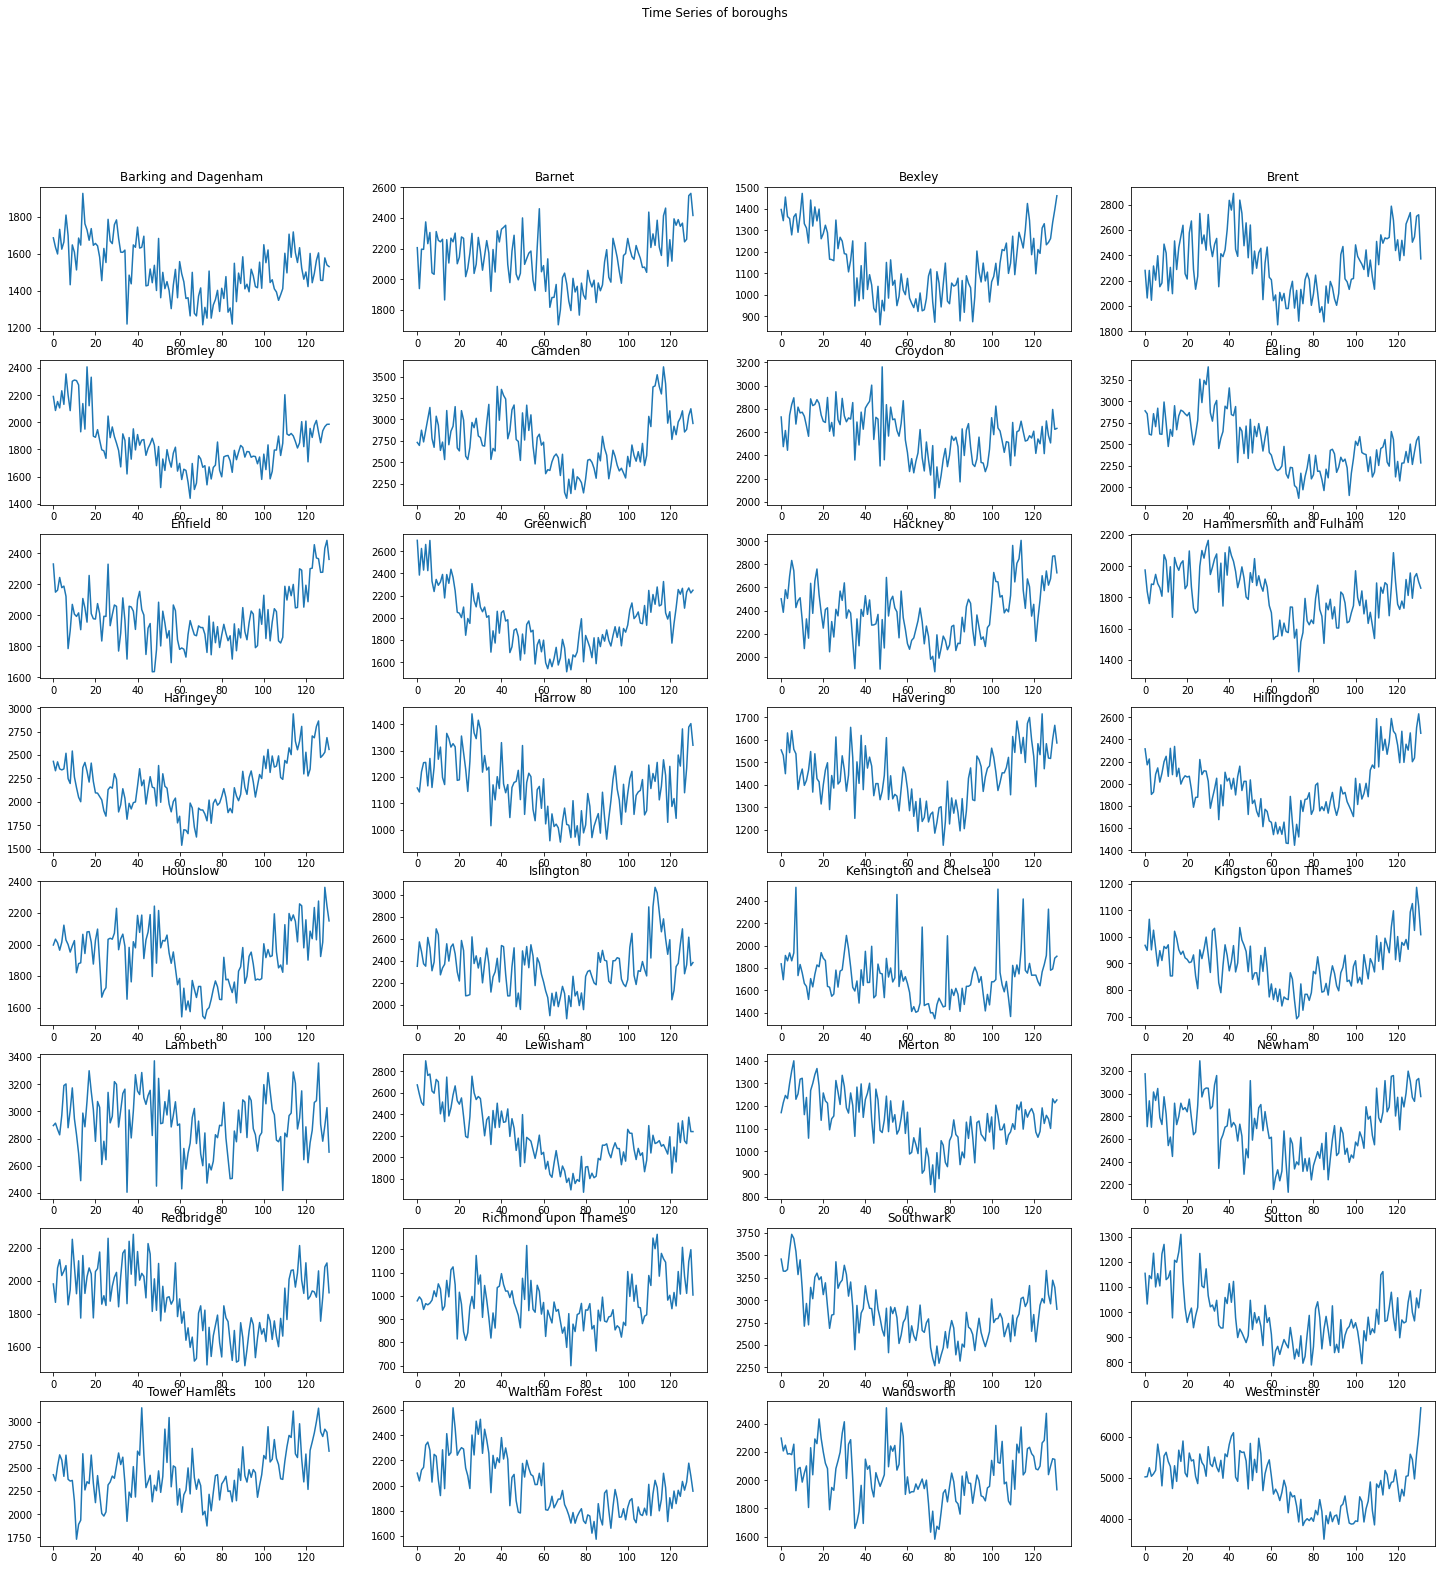

In [ ]:
# plot time series of all boroughs
fig, axs = plt.subplots(8,4,figsize=(25,25))
fig.suptitle('Time Series of boroughs')
for i in range(8):
    for j in range(4):
        if i*4+j+1>len(df1.columns): # pass the others that we can't fill
            continue
        axs[i, j].plot(df1[df1.columns[i*4+j+1]].values)
        axs[i, j].set_title(df1.columns[i*4+j+1])
plt.show()

By plotting the time series for the different boroughs, it can be found that there is a very large variation in crime between boroughs. Bexley, for example, shows a U-shaped trend, while Brent looks like a skewed Z.

In [ ]:
df2 = df1.drop(['Date'],axis=1)

In [ ]:
# Data standardisation for clustering

for c in df2.columns.values:
    scaler = MinMaxScaler()
    df2[c] = scaler.fit_transform(df2[c].values.reshape(-1, 1))

In [ ]:
df2 = df2.T
df2.head(3)

DateTime,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,2010-11-01,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,...,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
Borough,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,0.661495,0.590973,0.538787,0.726375,0.575458,0.630465,0.834979,0.678420,0.304654,0.607898,0.552891,0.417489,0.660085,0.606488,1.000000,0.768688,0.722144,0.643159,0.732017,0.605078,0.619182,0.600846,0.514810,0.335684,0.581100,0.473907,0.802539,0.637518,0.617772,0.761636,0.798307,0.658674,0.552891,0.551481,0.568406,0.005642,0.377997,0.311707,0.607898,0.589563,...,0.308886,0.251058,0.423131,0.372355,0.290550,0.282087,0.476728,0.277856,0.609309,0.472496,0.569817,0.321580,0.342736,0.273625,0.249647,0.186178,0.228491,0.275035,0.544429,0.394922,0.689704,0.513399,0.706629,0.548660,0.473907,0.586742,0.431594,0.346968,0.401975,0.290550,0.543018,0.320169,0.390691,0.490832,0.547250,0.338505,0.337094,0.509168,0.455571,0.442877
Barnet,0.586931,0.275379,0.575263,0.574096,0.782964,0.617270,0.702450,0.395566,0.383897,0.709452,0.642940,0.631272,0.651109,0.189032,0.647608,0.470245,0.659277,0.631272,0.697783,0.464411,0.514586,0.668611,0.658110,0.366394,0.430572,0.544924,0.695449,0.390898,0.460910,0.665111,0.558926,0.415403,0.528588,0.640607,0.546091,0.254376,0.572929,0.401400,0.715286,0.630105,...,0.324387,0.658110,0.589265,0.512252,0.406068,0.316219,0.527421,0.542590,0.656943,0.577596,0.519253,0.498250,0.603267,0.549592,0.505251,0.436406,0.438740,0.399067,0.857643,0.588098,0.691949,0.604434,0.795799,0.591599,0.527421,0.829638,0.887981,0.445741,0.647608,0.484247,0.806301,0.757293,0.800467,0.749125,0.773629,0.631272,0.651109,0.982497,1.000000,0.831972
Bexley,0.877250,0.792144,0.972177,0.823241,0.808511,0.684124,0.821604,0.844517,0.703764,0.834697,1.000000,0.769231,0.736498,0.621931,0.949264,0.751227,0.896890,0.790507,0.880524,0.654664,0.693944,0.757774,0.700491,0.499182,0.495908,0.487725,0.797054,0.579378,0.666121,0.636661,0.541735,0.536825,0.402619,0.489362,0.638298,0.142390,0.356792,0.183306,0.450082,0.198036,...,0.214403,0.561375,0.404255,0.325696,0.469722,0.333879,0.400982,0.173486,0.327332,0.368249,0.468085,0.301146,0.471358,0.572831,0.564648,0.621931,0.391162,0.469722,0.674304,0.381342,0.543372,0.703764,0.648118,0.584288,0.721768,0.923077,0.793781,0.533552,0.657938,0.387889,0.572831,0.543372,0.736498,0.769231,0.608838,0.626841,0.656301,0.779051,0.875614,0.981997


In [ ]:
cluster_count = math.ceil(math.sqrt(len(df2))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

labels = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw").fit_predict(df2)
labels

array([1, 4, 3, 2, 3, 2, 4, 1, 4, 3, 2, 3, 4, 4, 0, 4, 0, 2, 5, 4, 2, 3,
       3, 4, 3, 2, 3, 3, 2, 1, 2, 4])

In [ ]:
df3 = np.array(df2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

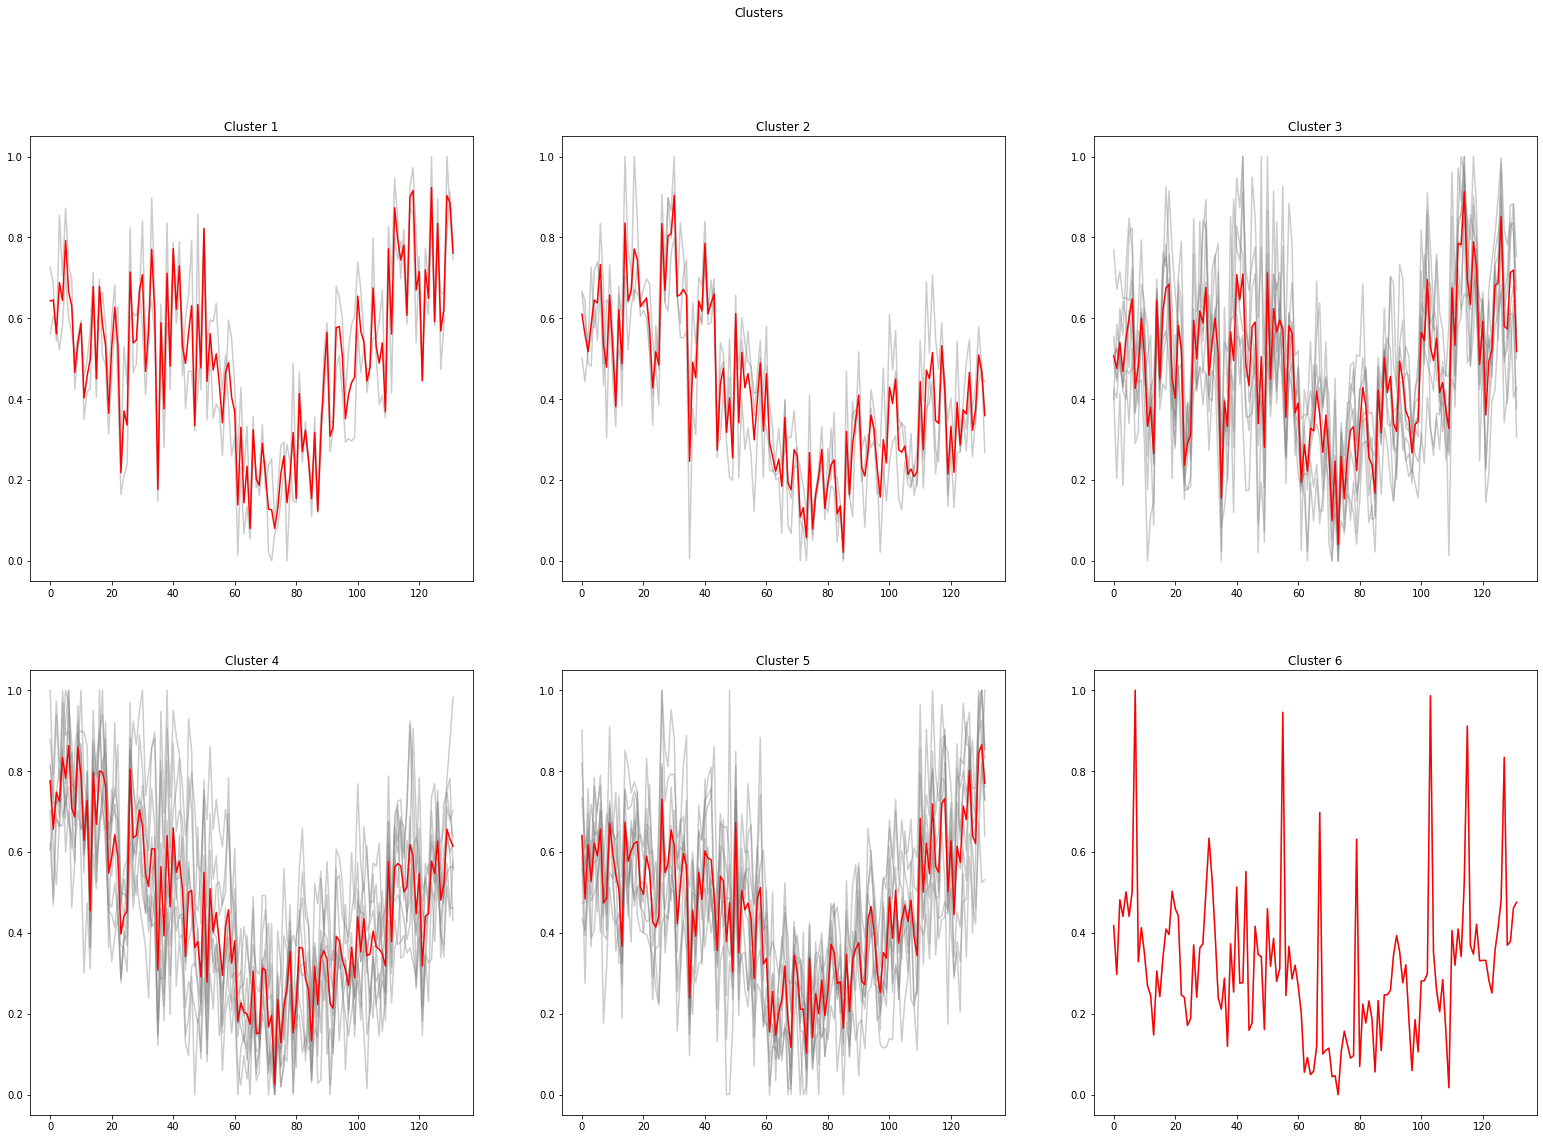

In [ ]:
## plot clustering results

plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(2,plot_count,figsize=(27,18))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in range(6):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(df3[i],c="gray",alpha=0.4)
                cluster.append(df3[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(label + 1))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        

plt.savefig('cases_total.png')
files.download("cases_total.png")
plt.show()

#plt.savefig('cases_total.png')
#files.download("cases_total.png") 

The DTW method gives different results each time. We choose the one that looks like the best clustering result after several attempts, as shown below.

**Fig.2  |  Time Series Clustering Result**

![](https://raw.githubusercontent.com/YaleGu/DSSS_final/main/cases_total.png)

By clustering the time series, we divide them into six groups, each with characteristics that differ from those of the other groups:
1. Between 2008 and 2012, there is no very clear downward trend in crime cases in the first cluster, which fluctuates roughly up and down in a range. And for a short time at the end of 2012 there is a sudden and sharp decline, and the trough is maintained for about 20 months out before starting to climb again. and the data on the rightmost side is higher than on the leftmost side. The shape resembles a 'Z'.

2. Cluster 2 experiences a rise in crime in the first 40 months and then begins to fall until around the 60th month and reaches its lowest value in the 72nd month. Then, in line with the general trend, the figure gradually rises and eventually lands lower than the start of 2008.

3. The third group shares a pattern with the first group, but the cases remain less volatile than in the first group. The difference between the leftmost and rightmost group is also smaller than in the first group.

4. The trend in the group 4 is similar to the trend in the total cases. However, in the time series of total case for the 32 boroughs, the case data for January 2008 is essentially the same as that for December 2018. Whereas the December 2018 data for the first group is lower than the January 2008.


5. The trend in cluster 5 looks like a mirror flip of the first group. The right-hand side is slightly higher than the left-hand side. At the same time, the range of fluctuations in the third group is smaller than in the first group, i.e. the variance is smaller.

6. It can be noted that there is only one borough in the group 6, Kensington and Chelsea. It has a spike at certain intervals and then a rapid drop in the following month, but for the most part it remains at a low level in crime compared to the other groups.


In [ ]:
df2['clustering'] = labels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

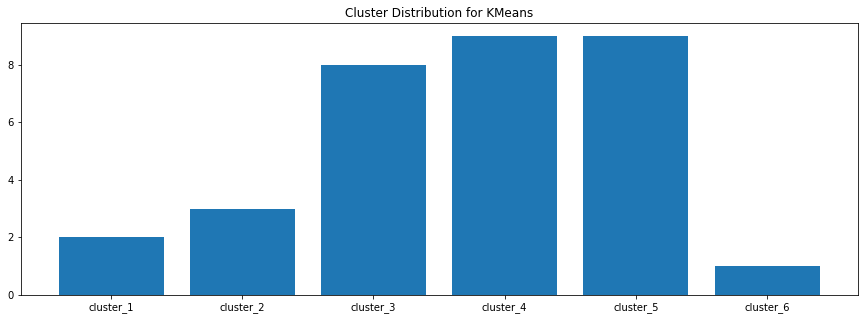

In [ ]:
# histogram of clustering results
# the result of dtw will influence the plot below, therefore we attach the diagram that corresponds to the previous one below.
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i + 1) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)


plt.savefig('cluster distribution.png')
files.download("cluster distribution.png") 
plt.show()

**Fig.3 | Clustering Distribution**

![](https://raw.githubusercontent.com/YaleGu/DSSS_final/main/cluster%20distribution%20(1).png)

The histogram reveals that the majority of samples join the cluster 4 and 5. This cluster follows roughly the same trend as the data for the total cases. Cluster 4 differs from cluster 5 mainly in that the rate of descent in this cluster is higher than the rate of ascent, while the opposite is true for cluster 5.

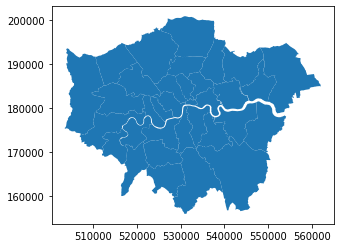

In [ ]:
## import map for visualisation

path = 'https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true'
map_bor = gpd.read_file(path)
map_bor.plot()

In [ ]:
tsClusteringResult = pd.DataFrame(df2['clustering']+1,dtype="category")
tsClusteringResult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Barking and Dagenham to Westminster
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   clustering  32 non-null     category
dtypes: category(1)
memory usage: 1.7+ KB


In [ ]:
# Merge the clustering results into the attribute table of the map
map1 = map_bor.merge(tsClusteringResult,left_on='NAME', right_on='Borough')
map1

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,clustering
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407....",5
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.200 159504.700, 535005....",5
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.600 157530.400, 540361....",4
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.800 178100.000, 521967....",1
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.500 182881.600, 510249....",2
5,Havering,E09000016,11445.735,210.763,F,"MULTIPOLYGON (((549893.900 181459.800, 549894....",1
6,Hillingdon,E09000017,11570.063,0.000,F,"MULTIPOLYGON (((510599.800 191689.500, 510615....",5
7,Harrow,E09000015,5046.330,0.000,F,"MULTIPOLYGON (((510599.800 191689.500, 510660....",5
8,Brent,E09000005,4323.270,0.000,F,"MULTIPOLYGON (((525201.000 182512.600, 525181....",3
9,Barnet,E09000003,8674.837,0.000,F,"MULTIPOLYGON (((524579.900 198355.200, 524594....",5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

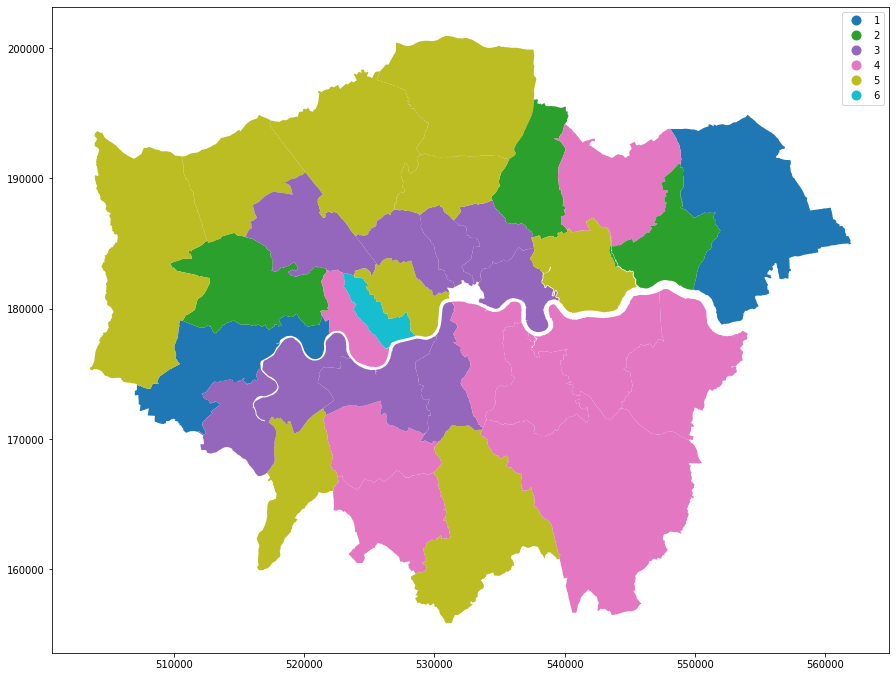

In [ ]:
# plot clustering results on the map
## the result of dtw will influence the plot below, therefore we attach the diagram that corresponds to the previous two below.

fig, ax = plt.subplots(1,1,figsize=(15,15),)
map1.plot(column='clustering',ax=ax, legend=True)

plt.savefig('map1.png')
files.download("map1.png") 

**Fig.4 | map of time series clustering**

![](https://raw.githubusercontent.com/YaleGu/DSSS_final/main/map1.png)

We present the clustering results on the map and find it interesting that group 4 is mainly concentrated in the north-west part of London, while group 5 is mainly clustered in south-east. In looking back at the time series, it is found that Group 5 has lower crime cases than Group 4 prior to 2014, while this is reversed after 2014.

### **4.2 Clustering of the composition of crime types**

In this part we select the median of each type of crime in each borough as the attribute value and then perform a hierarchical clustering of them with the aim of exploring the dissimilarity in the composition of crime types in different areas.

In [ ]:
# data preprocessing

df5 = df.drop(['Minor Category'],axis=1)
df5

,Borough,Major Category,200801,200802,200803,200804,200805,200806,200807,200808,200809,200810,200811,200812,200901,200902,200903,200904,200905,200906,200907,200908,200909,200910,200911,200912,201001,201002,201003,201004,201005,201006,201007,201008,201009,201010,201011,201012,201101,201102,...,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
0,Barking and Dagenham,Burglary,82,71,87,74,74,103,113,96,95,107,120,148,180,149,155,112,135,119,149,124,159,180,184,157,169,161,123,118,102,124,137,153,136,116,140,105,165,122,...,77,105,111,119,103,86,73,47,77,63,55,54,49,60,73,100,118,124,93,101,129,71,95,83,81,122,88,124,143,134,122,75,93,77,94,84,99,94,106,163
1,Barking and Dagenham,Burglary,59,68,56,53,57,39,44,37,52,65,52,67,51,67,64,80,69,51,56,49,58,39,51,55,53,47,49,49,58,59,47,46,51,52,62,49,50,51,...,50,34,36,32,44,53,32,42,42,47,32,33,45,40,24,19,40,78,67,53,68,57,72,47,42,47,53,49,67,48,61,65,39,52,40,36,50,61,60,50
2,Barking and Dagenham,Criminal Damage,79,52,55,73,63,80,73,75,59,68,71,55,70,74,56,61,65,69,62,59,58,44,56,48,50,67,39,63,58,55,67,65,39,59,51,48,59,49,...,28,28,36,38,36,39,50,36,58,30,48,38,31,29,32,26,28,31,36,31,32,46,48,49,28,35,32,28,34,23,30,29,32,29,21,29,23,35,21,15
3,Barking and Dagenham,Criminal Damage,142,138,118,158,126,96,116,123,103,102,106,111,115,107,173,134,151,97,103,80,72,88,92,66,95,69,114,97,81,114,80,78,80,93,80,56,71,76,...,68,65,80,105,75,83,73,61,81,73,69,68,61,69,67,59,65,62,61,61,71,59,66,77,72,63,48,57,60,51,53,64,64,67,69,42,38,42,47,33
4,Barking and Dagenham,Criminal Damage,20,19,20,23,16,12,17,18,14,14,14,9,22,21,16,24,19,12,9,21,7,15,12,12,12,18,13,17,16,14,27,16,10,12,21,9,14,10,...,10,9,16,10,13,10,21,13,13,18,15,16,11,12,16,8,10,6,13,9,7,12,6,8,7,12,11,10,10,5,6,9,8,8,7,7,11,5,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,Westminster,Violence Against the Person,207,191,187,185,233,223,259,234,228,233,221,204,203,205,250,206,257,218,267,221,231,232,227,191,220,181,234,195,211,248,281,205,198,183,182,137,176,176,...,291,242,288,293,229,235,249,261,275,300,404,339,342,323,296,297,265,292,360,346,373,421,429,411,345,389,387,341,354,344,346,388,415,428,446,389,414,391,388,386
1052,Westminster,Violence Against the Person,0,1,2,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,4,2,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1053,Westminster,Violence Against the Person,27,20,22,21,24,37,39,38,17,32,28,33,29,22,23,20,20,23,18,16,25,23,16,15,17,21,27,16,14,15,15,26,15,16,18,10,23,16,...,26,23,16,6,12,4,26,18,23,25,21,44,19,34,22,22,26,21,25,34,35,21,24,66,23,42,23,20,34,24,23,38,29,29,33,46,28,30,24,41
1054,Westminster,Violence Against the Person,38,25,32,24,22,42,61,50,42,35,45,40,39,25,33,38,44,31,38,37,36,32,47,39,30,45,40,41,34,58,37,32,34,51,31,41,39,40,...,33,23,47,40,52,24,52,57,48,47,53,47,59,39,59,49,117,90,104,51,55,41,47,52,42,71,104,59,85,67,61,57,88,70,79,83,36,43,37,38


In [ ]:
# Extract the median value

df6 = df5.groupby(['Borough','Major Category'], as_index=False).sum()
df6['median_cases'] = df6.median(axis=1)
df7 = df6[['Borough','Major Category','median_cases']]
df7

,Borough,Major Category,median_cases
0,Barking and Dagenham,Burglary,167.0
1,Barking and Dagenham,Criminal Damage,158.5
2,Barking and Dagenham,Drugs,88.5
3,Barking and Dagenham,Fraud or Forgery,5.0
4,Barking and Dagenham,Other Notifiable Offences,28.0
...,...,...,...
283,Westminster,Other Notifiable Offences,69.0
284,Westminster,Robbery,168.5
285,Westminster,Sexual Offences,55.0
286,Westminster,Theft and Handling,2841.5


In [ ]:
## create pivot tables that can be used for hierarchical clustering

df8 = df7.pivot(index='Borough', columns='Major Category', values='median_cases')
df8

Major Category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
Borough,,,,,,,,,
Barking and Dagenham,167.0,158.5,88.5,5.0,28.0,57.0,27.0,483.0,430.5
Barnet,341.0,183.5,82.5,8.5,29.0,66.0,30.0,838.0,431.5
Bexley,136.0,144.0,65.0,2.0,19.0,22.0,19.0,375.5,298.5
Brent,276.5,190.0,243.5,7.0,38.5,123.0,34.0,696.5,623.0
Bromley,253.5,197.5,80.5,5.5,26.0,45.0,27.0,657.5,466.5
Camden,271.5,159.5,168.0,7.5,37.0,90.5,34.0,1330.0,509.5
Croydon,303.0,273.0,175.0,6.5,44.0,114.0,46.5,835.0,619.0
Ealing,273.5,219.5,155.0,8.5,43.0,83.5,37.0,864.5,662.0
Enfield,289.0,191.0,112.5,7.5,34.0,87.0,33.0,693.5,409.0


In [ ]:
# correlation coefficient matrix
df8.corr().style.background_gradient(cmap='Blues')

Major Category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
Major Category,,,,,,,,,
Burglary,1.000000,0.785665,0.609422,0.652341,0.703494,0.718768,0.748395,0.539996,0.730704
Criminal Damage,0.785665,1.000000,0.587378,0.481395,0.767959,0.706421,0.841945,0.380797,0.864112
Drugs,0.609422,0.587378,1.000000,0.750881,0.905406,0.882350,0.840473,0.810311,0.837559
Fraud or Forgery,0.652341,0.481395,0.750881,1.000000,0.778389,0.719444,0.721539,0.838640,0.686497
Other Notifiable Offences,0.703494,0.767959,0.905406,0.778389,1.000000,0.866813,0.929654,0.815554,0.932117
Robbery,0.718768,0.706421,0.882350,0.719444,0.866813,1.000000,0.924713,0.693808,0.875760
Sexual Offences,0.748395,0.841945,0.840473,0.721539,0.929654,0.924713,1.000000,0.701651,0.937713
Theft and Handling,0.539996,0.380797,0.810311,0.838640,0.815554,0.693808,0.701651,1.000000,0.641178
Violence Against the Person,0.730704,0.864112,0.837559,0.686497,0.932117,0.875760,0.937713,0.641178,1.000000


**Fig.5 | Correlation Coefficient Matrix**

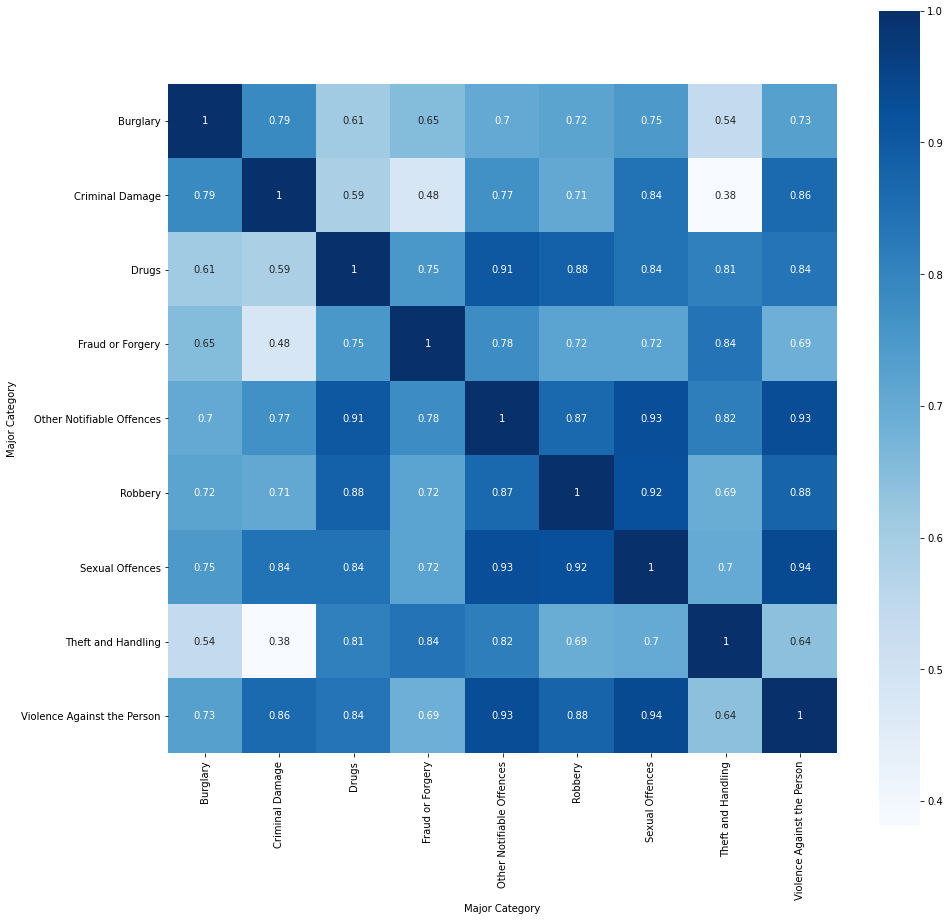

In [ ]:
plt.subplots(figsize=(15, 15))
sns.heatmap(df8.corr(), annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

The correlation coefficient matrix shows that there is generally a strong positive correlation between different types of crime.

In [ ]:
# # Data standardisation for clustering

for c in df8.columns.values:
    scaler = MinMaxScaler()
    df8[c] = scaler.fit_transform(df8[c].values.reshape(-1, 1))

df8.head(2)

Major Category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
Borough,,,,,,,,,
Barking and Dagenham,0.292683,0.370879,0.162479,0.24,0.267857,0.273616,0.300,0.054141,0.422422
Barnet,1.000000,0.508242,0.142379,0.52,0.285714,0.332248,0.375,0.196511,0.424215


**Fig.6 | Hierarchical Clustering Dendrogram (A)**

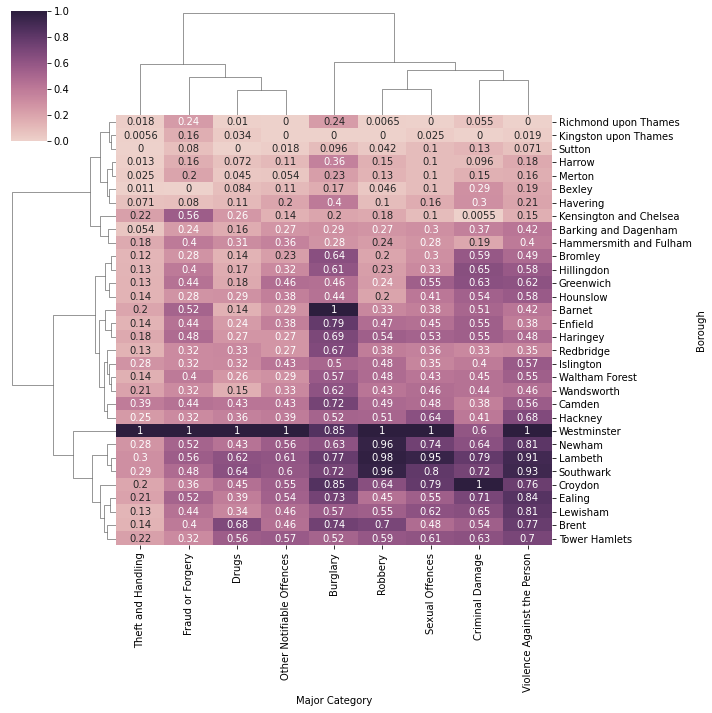

In [ ]:
sns.clustermap(df8,method ='ward',metric='euclidean', cmap=sns.cubehelix_palette(as_cmap=True), annot=True)

Here we want to investigate the variance in the composition of crime types across clusters using a hierarchical clustering dendrogram. We do not reduce the dimensionality of the features, as this would result in a loss of information to accurately identify the impact of each type of crime on the indicators.

**Fig.7 | Hierarchical Clustering Dendrogram (B)**

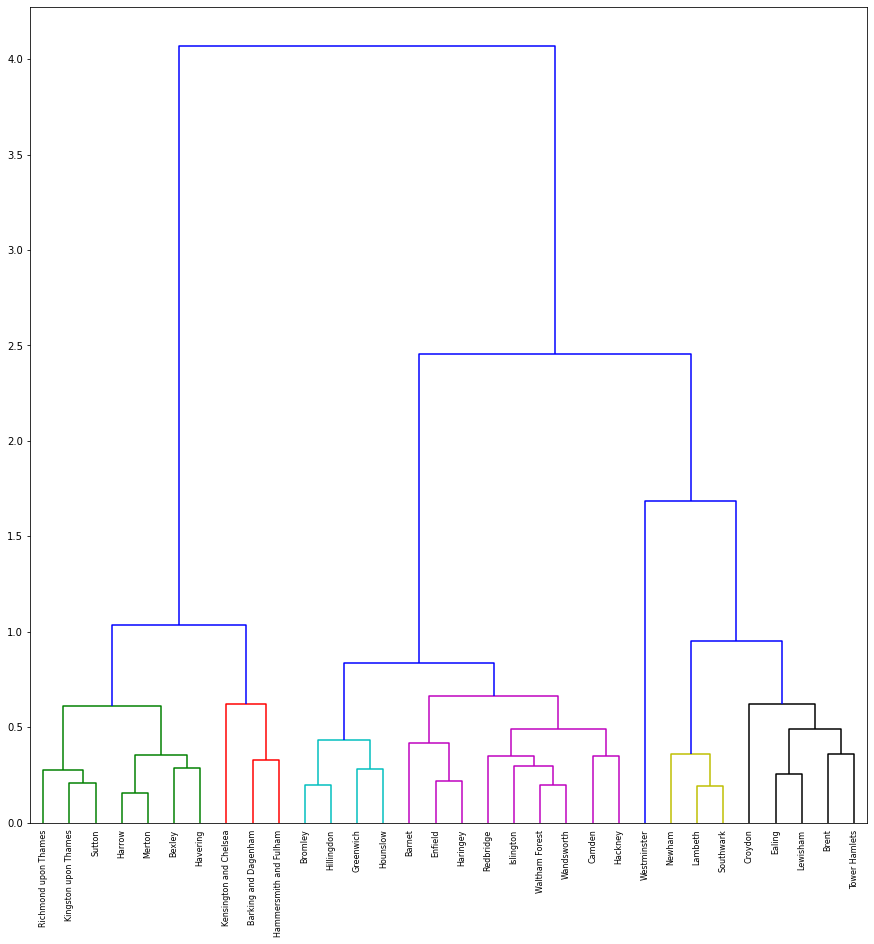

In [ ]:
Z = hierarchy.linkage(df8, method ='ward',metric='euclidean')

plt.subplots(figsize=(15, 15))
hierarchy.dendrogram(Z,labels = df8.index,leaf_rotation=90,color_threshold=0.8)
plt.show()

Based on the two graphs above, it can be seen that the green (Cluster 5 on the map below) group has lower values (less than 0.4) for each crime type.

The red (Cluster 2) one has slightly higher values than the green group for all indicators, especially Fraud or Forgery and Violence Against the Person.

The sky-blue (Cluster 7) group, on the other hand, is characterised by higher values for Theft and Handling, Criminal Damage and Violence Against the Person than the other categories.

The purple (Cluster 1) group suffers from theft much more frequently than the rest of the categories.

Westminster stands alone (Cluster 4) and it is much higher than the other groups in all types of crime data. Seven of the nine indicator values standardised can be identified as receiving the highest weight of 1. The remaining two are also highly weighted (0.85 and 0.6), suggesting a more serious crime situation in the borough.

The lime group (Cluster 6), for its part, holds a high weight value in robbery, close to 1, and black (Cluster 3) has the most serious violence against the person.

In [ ]:
# results of hierarchical clustering
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(df8)
y_hc

array([1, 0, 4, 2, 6, 0, 2, 2, 0, 6, 0, 1, 0, 4, 4, 6, 6, 0, 1, 4, 5, 2,
       4, 5, 0, 4, 5, 4, 2, 0, 0, 3])

In [ ]:
df9 = df8
df9['clustering']=y_hc

**Fig.8 | Clustering Distribution**

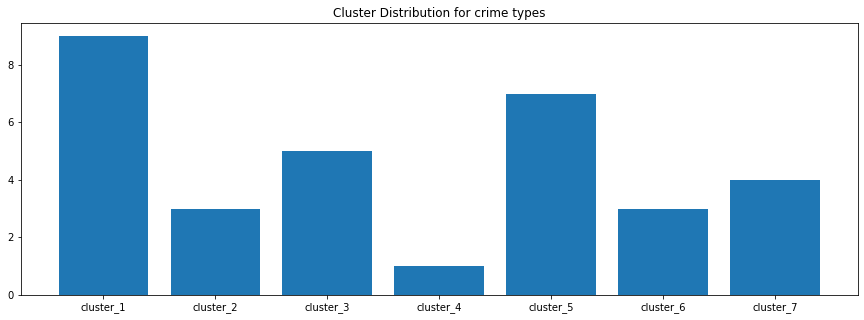

In [ ]:
# Cluster distribution results 
cluster_c2 = [len(y_hc[y_hc==i]) for i in range(7)]
cluster_n2 = ["cluster_"+str(i + 1) for i in range(7)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for crime types")
plt.bar(cluster_n2,cluster_c2)
plt.show()

In [ ]:

hClusteringResult = pd.DataFrame(df8['clustering']+1,dtype="category")
hClusteringResult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Barking and Dagenham to Westminster
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   clustering  32 non-null     category
dtypes: category(1)
memory usage: 664.0+ bytes


In [ ]:
# Merge the clustering results into the attribute table of the map
map2 = map_bor.merge(hClusteringResult,left_on='NAME', right_on='Borough')

**Fig.9 | map of hierarchical clustering**

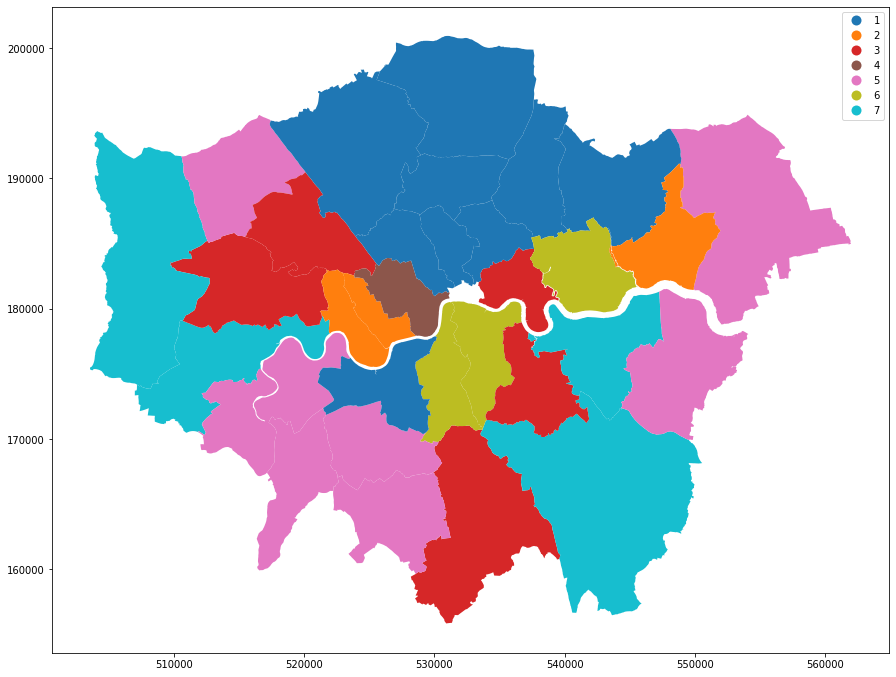

In [ ]:
# plot clustering result on the map
fig, ax = plt.subplots(1,1,figsize=(15,15),)
map2.plot(column='clustering',ax=ax, legend=True)

The clustering on the map demonstrates that Cluster 1 appears to be spatially aggregated. It is mainly located in north London.

When compared with the map of time series clustering, it emerges that 4 groups of areas with geographic adjacency are consistent in both clustering outcomes:
1. Merton and Sutton, which is located in south London. 
2. Greenwich and Bromley in south-east London.
3. Haringey, Enfield as well as Barnet in north London.
4. Hackney, Islington, Camden (in the north of city of London)


### **4.3 Time Series Prediction**

Beginning here, the time series of total cases are predicted with ANN and LSTM respectively. The fitting results of the two are then compared.

In [ ]:
# data preprocessing
df4 = df1.drop(['Date'],axis=1)
df4['Total'] = df1.sum(axis=1)
df4 = pd.DataFrame(df4['Total'])
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2008-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Total   132 non-null    int64
dtypes: int64(1)
memory usage: 2.1 KB


In [ ]:
# Data standardisation for deep learning
for c in df4.columns.values:
    scaler = MinMaxScaler()
    df4[c] = scaler.fit_transform(df4[c].values.reshape(-1, 1))

Here we split the time series into two parts. The first 100 data points are treated as training set (76%) and the last 32 points (24%) as test set.

**Fig.10 | Training Set and Test Set of time series**

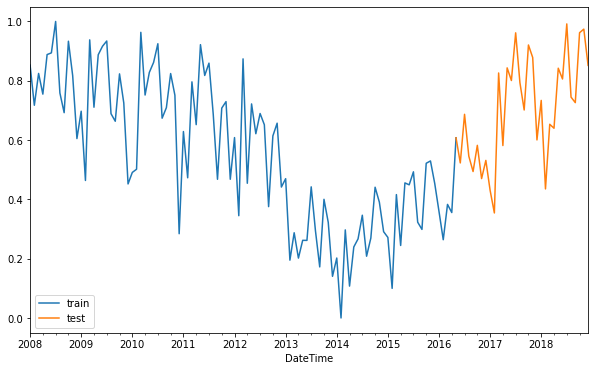

In [ ]:
model =  df4['Total']
train = model.iloc[:101]
test = model.iloc[100:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

***ANN Model***

In [ ]:
# Differentiating the data
predict_days = 1
X_train = train[:-predict_days]
y_train = train[predict_days:]
 
X_test = test[:-predict_days]
y_test = test[predict_days:]


In [ ]:
# set up the ANN model

nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 12)                24        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# run the ANN model

nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
100/100 [==============================] - 0s 723us/step - loss: 1.0303
Epoch 2/100
100/100 [==============================] - 0s 688us/step - loss: 0.3781
Epoch 3/100
100/100 [==============================] - 0s 702us/step - loss: 0.1284
Epoch 4/100
100/100 [==============================] - 0s 774us/step - loss: 0.0642
Epoch 5/100
100/100 [==============================] - 0s 746us/step - loss: 0.0498
Epoch 6/100
100/100 [==============================] - 0s 740us/step - loss: 0.0460
Epoch 7/100
100/100 [==============================] - 0s 692us/step - loss: 0.0441
Epoch 8/100
100/100 [==============================] - 0s 779us/step - loss: 0.0428
Epoch 9/100
100/100 [==============================] - 0s 791us/step - loss: 0.0417
Epoch 10/100
100/100 [==============================] - 0s 677us/step - loss: 0.0407
Epoch 11/100
100/100 [==============================] - 0s 762us/step - loss: 0.0400
Epoch 12/100
100/100 [==============================] - 0s 749us/step - lo

In [ ]:
# Calculate the R2 score

y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.468
The R2 score on the Test set is:	-0.090


In [ ]:

y_test.index = pd.to_datetime(y_test.index)


In [ ]:
data = y_pred_test_nn
data_list = np.array(data).flatten().tolist()

ser = pd.Series(data_list)
ser.index = pd.to_datetime(y_test.index)
y_pred_test_nn = ser

**Fig.10 | Fitting performance of ANN model**

Part of the code is referenced to [here](https://blog.csdn.net/u010412858/article/details/76153000)

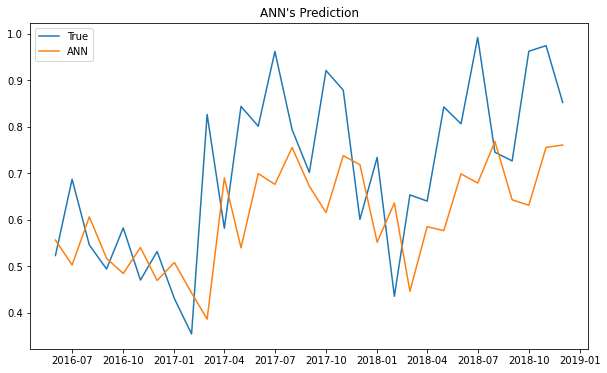

In [ ]:
# plot the prediction data and test data

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='ANN')
plt.title("ANN's Prediction")
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

***LSTM Model***

In [ ]:
# convert array into matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1

trainX, trainY = create_dataset(train.values.reshape(101,1), look_back)
testX, testY = create_dataset(test.values.reshape(32,1), look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# set up LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(1, look_back),activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
99/99 [==============================] - 1s 1ms/step - loss: 0.4194
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.2977
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1973
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1255
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0828
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0616
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0520
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0477
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0455
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 13/100
99/99 [=================

In [ ]:
# Calculate the R2 score
y_pred_test_lstm = model.predict(testX)
y_train_pred_lstm = model.predict(trainX)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(trainY, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(testY, y_pred_test_lstm)))


The R2 score on the Train set is:	0.492
The R2 score on the Test set is:	-0.007


**Fig.11 | Fitting performance of LSTM model**

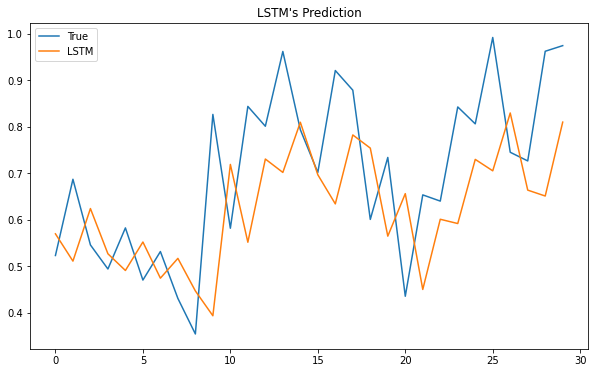

In [ ]:
# plot the prediction data and test data

plt.figure(figsize=(10, 6))
plt.plot(testY, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show();


In [ ]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = model.evaluate(testX, testY, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)


30/30 [==============================] - 0s 834us/step - loss: 0.0320
NN: 0.034313
LSTM: 0.032010


Here we use the mean squared error as an indicator of the performance of the model. It can be seen that the MSE of the LSTM is 0.0024 less than that of the ANN. There is no significant difference between the results of the two models, although the MSE of the LSTM is slightly lower than that of the ANN.

## 5 Discussion and Conclusion
We use DTW to calculate the time series similarity and perform K-means clustering based on this. The results show that half of the samples are clustered in the two groups with similar trends to the total cases, indicating that a fair number of Boroughs have homogenous crime data. Geographically, the two most numerous clusters are mainly located in the northwest and southeast, respectively. It can be speculated that spatio-temporal correlation is displayed in both groups. In future studies, it is possible to dig deeper into potentially relevant variables (e.g. population mobility, income, unemployment rate etc.) to explain such spatio-temporal correlation.

One of the clusters from the hierarchical clustering of crime composition is geographically aggregated (in North London). This area has a higher frequency of theft than other kinds of crime. We focus primarily on similarity in the composition of crime types. A limitation of this part is that the data on cases are not divided by the number of people or by the area of the region, making comparisons between boroughs difficult. This could be improved later in the research.

The MSE of the LSTM is slightly lower than that of the ANN, indicating that the LSTM outperforms the ANN in forecasting the time series of crime data. However, this difference is not significant and the fit of both is not very satisfactory. Follow-up optimization of the model is needed.

Recently, more and more cases tend to use hybrid model for forecasting time series. For example, Khandelwal et al.(2015) use hybrid ARIMA-ANN model. They decompose the time series into linear and non-linear components and apply separate models for forecasting, improving the accuracy of the forecasts. This may be used to improve this work.

## Reference

CHANDRA, B., GUPTA, M. & GUPTA, M. P. A multivariate time series clustering approach for crime trends prediction.  *2008 IEEE International Conference on Systems, Man and Cybernetics*, 12-15 Oct. 2008 2008. 892-896.

CHEN, H., CHUNG, W., XU, J. J., WANG, G., QIN, Y. & CHAU, M. 2004. Crime data mining: a general framework and some examples. *Computer,* 37, 50-56.

CHEN, P., YUAN, H. & SHU, X. Forecasting Crime Using the ARIMA Model.  2*008 Fifth International Conference on Fuzzy Systems and Knowledge Discovery*, 18-20 Oct. 2008 2008. 627-630.

FERNANDES, P. O. & TEIXEIRA, J. P. New approach of the ANN methodology for forecasting time series: use of time index.  *International Conference on Tourism Development and Management*, 2009.

KHASHEI, M., BIJARI, M. & ARDALI, G. A. R. 2009. Improvement of auto-regressive integrated moving average models using fuzzy logic and artificial neural networks (ANNs). *Neurocomputing*, 72, 956-967.

KIM, K.-J. 2003. Financial time series forecasting using support vector machines. *Neurocomputing*, 55, 307-319.

MARZAN, C. S., BACULO, M. J. C., BULOS, R. D. D. & RUIZ, C. 2017. Time Series Analysis and Crime Pattern Forecasting of City Crime Data. *Proceedings of the International Conference on Algorithms, Computing and Systems*. Jeju Island, Republic of Korea: Association for Computing Machinery.

ZHANG, Y., ZHAO, J., REN, L. & HOOVER, L. 2015. Space–Time Clustering of Crime Events and Neighborhood Characteristics in Houston. *Criminal Justice Review*, 40, 340-360.

